# VEME NGS Module: Single Cell Data Preprocessing

In this notebook we discuss some of the steps for processing raw counts from single cell RNA sequencing data.  We will use just one of the raw counts matrices from a single patient sample of the data published in Nature by Melms et al. at https://www.nature.com/articles/s41586-021-03569-1. The raw data we will be examining can be retrieved in GEO from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM5226581.  All of these pre-processing steps are discussed at https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

NOTE: The dataset we are going to process has already had some data processing by the original authors.  But since this is the raw counts data, we can still do some additional data processing and examine the changes.

In [1]:
%pip uninstall numpy -y
%pip install numpy==1.21.0

Found existing installation: numpy 1.21.0
Uninstalling numpy-1.21.0:
  Successfully uninstalled numpy-1.21.0
Note: you may need to restart the kernel to use updated packages.
  Using cached numpy-1.21.0-cp38-cp38-macosx_10_9_x86_64.whl (16.9 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-network 0.31.0 requires numpy>=1.22.4, but you have numpy 1.21.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


## ----- MUST RESTART KERNEL BEFORE RUNNING -----

In [2]:
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import warnings
import pickle
warnings.filterwarnings("ignore")

## 1.) Load in the raw counts matrix for a single sample

In [4]:
counts = pd.read_csv("GSM5226581_L01cov_raw_counts.csv.gz", compression = "gzip")
counts = counts.set_index(counts.columns[0])
counts = counts.transpose()
counts.head()

Unnamed: 0,AL627309.1,AL627309.5,AL627309.4,AL669831.2,LINC01409,FAM87B,LINC01128,LINC00115,FAM41C,AL645608.6,...,AC087190.2,AC136428.1,AC019183.1,AC105094.1,AC010485.1,VN1R2,AL031676.1,SMIM34A,AL050402.1,AL445072.1
CTTCTCTAGCCTATTG-1_8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CAGATACTCTACCAGA-1_8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TGAGTCACAAGACCTT-1_8,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TGTTCCGCACATATGC-1_8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TATCCTATCAGGTAAA-1_8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 2.) Convert cell by gene data matrix into anndata data structure

In [16]:
adata = ad.AnnData(counts)
adata.obs_names = list(counts.index)
adata.var_names = list(counts.columns)
adata.var['gene_ids'] = list(counts.columns)
adata

AnnData object with n_obs × n_vars = 3060 × 34546
    var: 'gene_ids'

## 3.) Data filtering based on gene and mitochondrial counts

### a. View the distribution of genes and counts before filtering

n_genes_by_counts = the number of genes expressed per cell

total_counts = the total UMI counts per cell

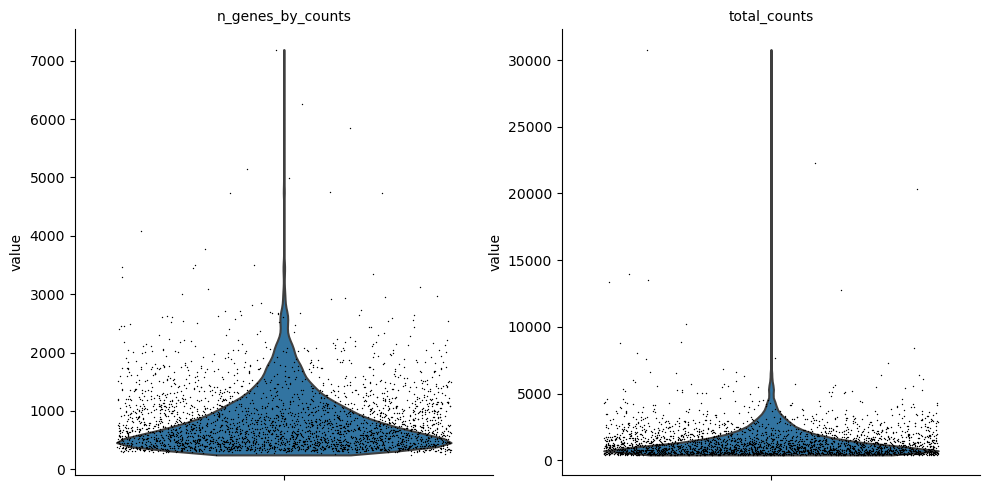

In [17]:
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'],jitter=0.4, multi_panel=True)

### b. Filter out cells with less than 100 genes and more than 3000 genes

In [18]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_cells(adata, max_genes=3000)
adata

AnnData object with n_obs × n_vars = 3042 × 34546
    obs: 'n_genes_by_counts', 'total_counts', 'n_genes'
    var: 'gene_ids', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

### c. Filter out cells with less than 100 UMI counts and more than 10000 UMI counts

In [19]:
sc.pp.filter_cells(adata, min_counts=100)
sc.pp.filter_cells(adata, max_counts=10000)
adata

AnnData object with n_obs × n_vars = 3042 × 34546
    obs: 'n_genes_by_counts', 'total_counts', 'n_genes', 'n_counts'
    var: 'gene_ids', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

### d. View the distribution of mitochodrial read counts

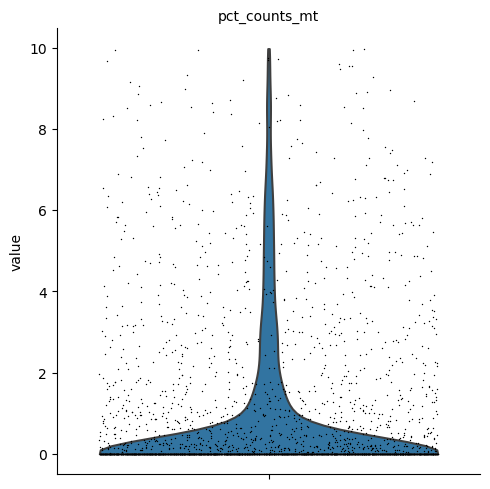

In [20]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ['pct_counts_mt'],jitter=0.4, multi_panel=True)

### e. Filter out cells with more than 5% mitochondrial read counts

In [21]:
adata = adata[adata.obs.pct_counts_mt < 5, :]
adata

View of AnnData object with n_obs × n_vars = 2859 × 34546
    obs: 'n_genes_by_counts', 'total_counts', 'n_genes', 'n_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mt'

### f. View the distribution of genes and counts after filtering

Trying to set attribute `.obs` of view, copying.


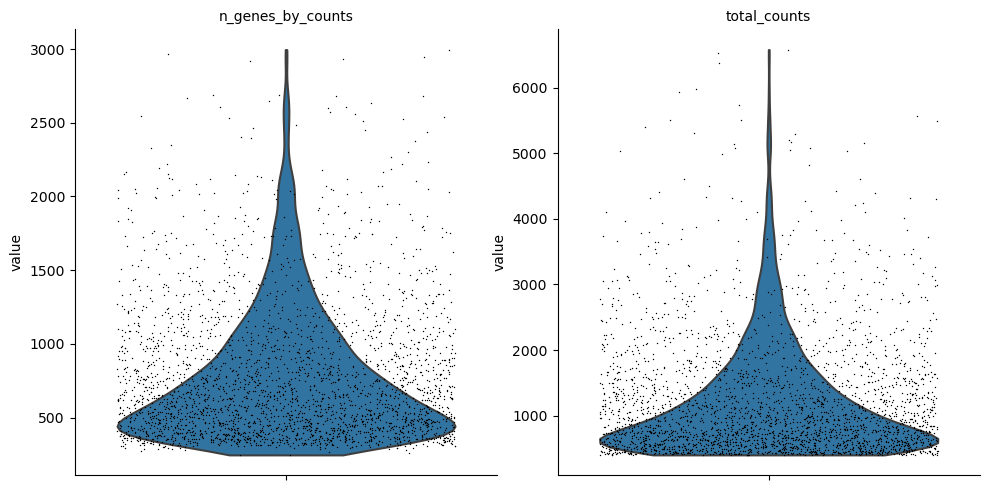

In [22]:
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'],jitter=0.4, multi_panel=True)

### g. View the distribution of mitochondrial gene counts after filtering

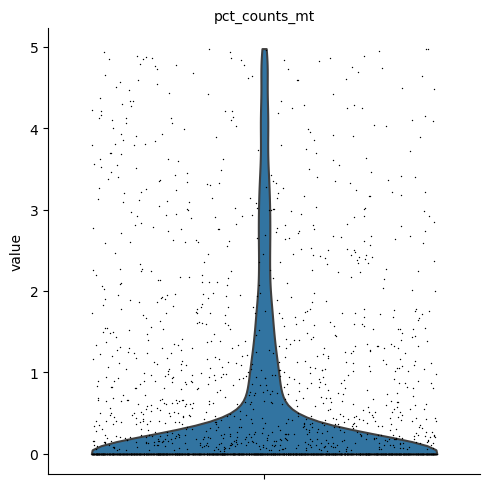

In [23]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ['pct_counts_mt'],jitter=0.4, multi_panel=True)

## 4.) Log-Normalizing, highy variable genes, and scaling

NOTE: Normally, we would not filter out genes until all the samples have been aggregated, because all the samples need the same gene dimension size to be concatenated.  But here we demonstrate how genes would get filtered out of the data and ultimately serve as an initial dimensionality reduction starting point.

### a. Remove genes that aren't expressed in at least 10 cells

In [24]:
sc.pp.filter_genes(adata, min_cells=10)
adata

AnnData object with n_obs × n_vars = 2859 × 15385
    obs: 'n_genes_by_counts', 'total_counts', 'n_genes', 'n_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mt', 'n_cells'

### b. Total count normalize to 1,000 reads per cell and log scale

In [25]:
sc.pp.normalize_total(adata, target_sum=1e3)
sc.pp.log1p(adata)

### c. Identify and visualize highly-variable genes

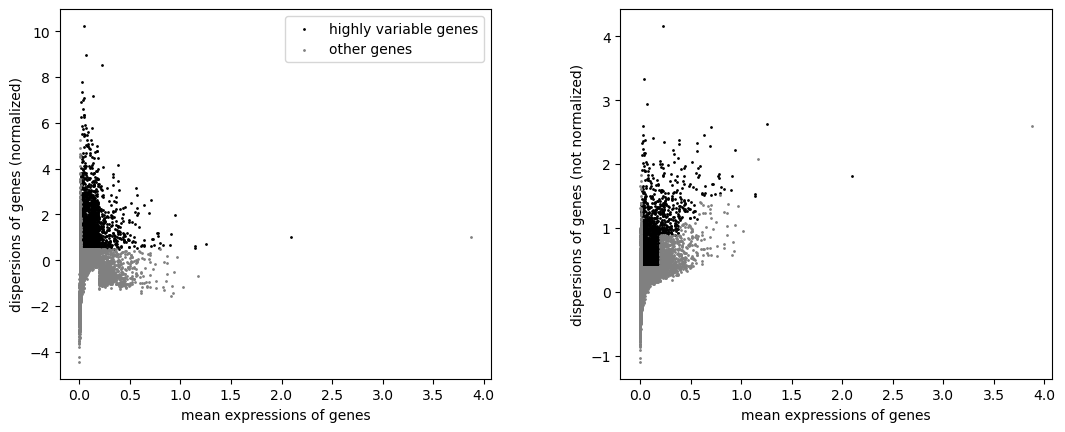

In [26]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

### d. Filter of highly variable genes

In [27]:
adata = adata[:, adata.var.highly_variable]
adata

View of AnnData object with n_obs × n_vars = 2859 × 2671
    obs: 'n_genes_by_counts', 'total_counts', 'n_genes', 'n_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mt', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

###
NOTE: We could also filter based on the top N variable genes, like the top 2000 variable genes

### e. Scale the data to unit variance

In [28]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)
adata

AnnData object with n_obs × n_vars = 2859 × 2671
    obs: 'n_genes_by_counts', 'total_counts', 'n_genes', 'n_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mt', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg'